In [1]:
import torch
import torch.functional as F
import torch.nn as nn
import spacy
import pandas as pd
import numpy as np
import random
import time
from torch.utils.data import Dataset, DataLoader
from spacy.lang.en.stop_words import STOP_WORDS
SEED=42
torch.manual_seed(SEED)
import re

In [2]:
df = pd.read_excel('Participants_Data_News_category/Data_Train.xlsx')

In [3]:
df = df.sample(frac = 1, random_state=42, axis = 0)

In [4]:
df.SECTION = df.SECTION.astype(int)

In [10]:
# min_count = np.min(df.SECTION.value_counts())
# min_count
# df2 = pd.DataFrame(columns=['STORY', 'SECTION'])
# texts = []
# classes = []
# for cat in range(4):
#     temp_idxs = df.index[df.SECTION==cat][:min_count]
#     frames = [df.iloc[temp_idxs, :], df2]
#     df2 = pd.concat(frames, sort=False)

# len(df2) / min_count
# df2.reset_index(drop = True, inplace=True)
# df2.reset_index(drop = True, inplace=True)

In [13]:
class Vocabulary(object):
    """Class to build vocabulary for mapping"""
    def __init__(self, token_to_idx = None, add_unk = True, unk_token = "<UNK>", mask_token="<MASK>", begin_seq_token="<BEGIN>",end_seq_token="<END>"):
        """
        Args:
            token_to_idx: Initialize token to idx dictionary.
            add_unk: Whether to include the unknown token in the vocabulary
            unk_token: How the unknown token is represented in the vocabulary
        """
        
        if token_to_idx is None:
            token_to_idx = {}
            
        self._token_to_idx = token_to_idx
        
        self._idx_to_token = {idx:token 
                             for token, idx in self._token_to_idx.items()}
        
#         self._mask_token = mask_token
        self._unk_token = unk_token
        self._begin_seq_token = begin_seq_token
        self._end_seq_token = end_seq_token

#         self.mask_index = self.add_token(self._mask_token)
        self.unk_index = self.add_token(self._unk_token)
        self.begin_seq_index = self.add_token(self._begin_seq_token)
        self.end_seq_index = self.add_token(self._end_seq_token)
        
        self._add_unk = add_unk
        
    def from_serializable(self):
        """
        Returns:
            A dictionary that can be serialized
        """

        return cls(**contents)
        
    def add_token(self, token):
        """ Update mapping dictionaries given the token
        Args:
            token (str): Token to add to the vocabulary
        Returns:
            index (int): The index corresponding to the token          
        """

        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token

        return index
        
    def lookup_token(self, token):
        """ Retrieves the index associated with the token
            or the UNK index if the token isn't present in the vocabulary

        Args:
            token (str): The token for which the index has to be retrieved
        Returns:
            index (int): The index associated with the token in the dictionary

        Note: 
            'UNK Index' has to be >=0 for the UNK functionality
        """

        if self._add_unk:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx.get(token)

    def lookup_index(self, index):
        """Retrieve the token associated with the index
        Args:
            index (int): The index to look up
        Returns:
            token (str): The token associated with the index
        Raises:
            KeyError: if the index is not in the vocabulary
        """

        if index not in self._idx_to_token:
            raise KeyError("the index %d is not in the vocabulary" % index)
        else:
            return self._idx_to_token[index]

    def __len__(self):
        """Returns the length of the vocabulary
        """
        return len(self._token_to_idx)      


In [14]:
class News_Category(Dataset):
    def __init__(self, df, nlp, vocab):
        """Initializing
        Args:
            df (Pandas DataFrame): Dataframe consisting of tweets and labels
            nlp (spacy object): For preprocessing
            vocab (Vocabulary Object): To vectorize the tweets
        """
        self.df = df
        self.nlp = nlp
        self.vocab = vocab
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, self.df.STORY)) + 1
        
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
          
        tweet =  self.df.STORY.iloc[idx]
        
        label = self.df.SECTION.iloc[idx]
        return {'tweet':torch.LongTensor(self.preprocess(tweet)), 'label':label}
    
    def preprocess(self, sent):
        
        #Preprocessing and tokenizing
        text = sent
        text = text.lower()
        text = re.sub(r"what's", "what is ", text)
        text = re.sub(r"\'s", " ", text)
        text = re.sub(r"\'ve", " have ", text)
        text = re.sub(r"can't", "can not ", text)
        text = re.sub(r"n't", " not ", text)
        text = re.sub(r"i'm", "i am ", text)
        text = re.sub(r"\'re", " are ", text)
        text = re.sub(r"\'d", " would ", text)
        text = re.sub(r"\'ll", " will ", text)
        text = re.sub(r"\'scuse", " excuse ", text)
        text = re.sub('\W', ' ', text)
        text = re.sub('\s+', ' ', text)
        text = text.strip(' ')
        text = re.sub('[^a-zA-Z]',' ',text)
        text=text.lower()
        sent = text
        sent =  " ".join(sent.split())
        sent = [token.lemma_ for token in self.nlp(sent) if token.text not in STOP_WORDS]
        sent = self.vectorize(sent)
        return sent
    
    def vectorize(self, sent):
        """Converts raw text to numeric vectors using the vocabulary
        Args:
            sent (str): The tweet to be vectorized
        Returns:
            vector (list): The vector associated with the tweet
        """
        vector = [self.vocab.begin_seq_index]
#         vector = []
        for token in sent:
            vector.append(vocab.lookup_token(token))
        vector.append(self.vocab.end_seq_index)
            
        return vector
    

In [15]:
vocab = Vocabulary(token_to_idx=None, add_unk=True)
nlp = spacy.load(name='en_core_web_sm')

def clean(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\\'s", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = re.sub('[^a-zA-Z]',' ',text)
    text=text.lower()
    text = " ".join(text.split())
    text = [token.lemma_ for token in nlp(text) if token.text not in STOP_WORDS]
    text = [w for w in text if len(w)>1]
    return text



In [16]:
for token in clean(df.STORY[0]):
    print(token)

painful
huge
reversal
fee
income
unheard
private
sector
lender
essentially
mean
yes
bank
take
grant
fee
structured
loan
deal
pay
account
upfront
book
borrower
turn
defaulter
fee
tie
loan
deal
fall
crack
gill
vow
shift
safe
accounting
practice
amortize
fee
income
book
upfront
gill
mend
past
way
mean
nasty
surprise
future
good
news
consider
investor
love
clean
image
loathe
uncertainty
gain
pain
promise
strong
stable
balance
sheet
come
sacrifice
investor
hope
phenomenal
growth
promise
kapoor


In [25]:
cleaned_tweets = df.STORY.apply(clean)
text = []

In [27]:
for i in range(len(cleaned_tweets)):
    for word in cleaned_tweets[i]:
        text.append(word)

In [28]:
len(text)

436335

In [37]:
from collections import Counter
count_dict = Counter(text).most_common(len(set(text))-500)

In [38]:
for tup in count_dict:
    vocab.add_token(tup[0])

In [36]:
count_dict[-1000:]

[('rerating', 1),
 ('navigational', 1),
 ('irns', 1),
 ('navic', 1),
 ('known', 1),
 ('tiranga', 1),
 ('handlebar', 1),
 ('likeness', 1),
 ('takedown', 1),
 ('frisk', 1),
 ('frisking', 1),
 ('demoralise', 1),
 ('newlywed', 1),
 ('nuptial', 1),
 ('karakurissi', 1),
 ('kalki', 1),
 ('tyagi', 1),
 ('reco', 1),
 ('garrett', 1),
 ('basch', 1),
 ('zaillian', 1),
 ('bron', 1),
 ('gilbert', 1),
 ('tethered', 1),
 ('usmovie', 1),
 ('dhar', 1),
 ('ashwatthama', 1),
 ('annapurna', 1),
 ('jvm', 1),
 ('liquidate', 1),
 ('ei', 1),
 ('shubham', 1),
 ('raheja', 1),
 ('splendor', 1),
 ('icicidirect', 1),
 ('bangade', 1),
 ('incidently', 1),
 ('maxis', 1),
 ('symbolism', 1),
 ('medically', 1),
 ('sedated', 1),
 ('naxalism', 1),
 ('balu', 1),
 ('hansraj', 1),
 ('saphi', 1),
 ('androidtv', 1),
 ('toggling', 1),
 ('outback', 1),
 ('feelthe', 1),
 ('avengerred', 1),
 ('skullhugo', 1),
 ('criminally', 1),
 ('justified', 1),
 ('shradha', 1),
 ('grape', 1),
 ('erlam', 1),
 ('utpal', 1),
 ('bhaskar', 1),
 ('ope

In [40]:
data = News_Category(df,nlp, vocab)

In [41]:
data[0]

{'tweet': tensor([    1, 20449, 24527, 15394, 24220, 20717, 16024,  7911, 17317, 13577,
          8647,     0, 10105, 15542, 11452, 15394, 14100, 12210, 17336, 21340,
          1144, 21536, 20559, 18065, 22543,  7102, 15394,  5660,  4034,  3207,
         16698, 17705,  4034,  2891,  4713, 23606,  1443,  6036,   169, 14175,
         14055, 14584, 20085, 12113,  2213,  1833, 22774,  4510,  1351,  3811,
          9498,  7718,  1025, 24575, 14584, 13931,     2]),
 'label': 1}

In [42]:
vocab.lookup_index(3)

'beginner'

In [43]:
def load_glove(filepath):
    """Loads the glove embeddings
    
    Args:
        filepath (str): path to the glove embeddings file
    Return:
        word_to_index (dict): Mappings from word to index
        embeddings (np.array): Embeddings of the words in the vocabulary
    """
    word_to_index = {}
    embeddings = []
    with open(filepath, 'r', encoding='utf-8') as fp:
        for index, line in enumerate(fp):
            line = line.split(" ")
            word_to_index[line[0]] = index
            embedding_i = np.array([float(val) for val in line[1:]])
            embeddings.append(embedding_i)
    
    return word_to_index, np.array(embeddings)

In [44]:
def make_embedding_matrix(filepath, words):
    """Create embedding matrix for a specific set of words
    Args:
        word_to_index (dict) : mapping of word to index
        embeddings (list): embeddings of words
        words (list): List of words in the dictionary
    Returns:
        final_embeddings (np..array) : embedding matrix
    """
    
    word_to_idx, embeddings = load_glove(filepath)
    embedding_size = embeddings.shape[1]
    final_embeddings = np.zeros((len(words), embedding_size))
    
    for i, word in enumerate(words):
        if word in word_to_idx:
            final_embeddings[i, :] = embeddings[word_to_idx[word]]
        else:
            embedding_i = torch.zeros(embedding_size)
            final_embeddings[i, :] = embedding_i
            
    return final_embeddings

In [45]:
words=[]
for idx in range(0, vocab.__len__()):
    words.append(vocab.lookup_index(idx))

In [46]:
embs = make_embedding_matrix(r"C:\Users\win10\Documents\glove.6B\glove.6B.300d.txt", words)

In [47]:
i=500
words[i], embs[i].shape

('nullah', (300,))

In [48]:
i = random.randint(0,4200)
print(i)
data[i]['tweet'], data[i]['label']

3944


(tensor([    1, 21507,  4780, 10259, 22374, 16099, 13212, 10903, 10034, 10188,
          1128, 23584,  6083, 17023, 22395,  5363, 14999, 22649,   831,  2676,
         22649,  7010, 11023,  6185,  6810, 22738,  6083,     0, 12490,  3440,
         17486,  7766, 14999,  3392, 10754, 18956, 12846,  8133, 22738,  1128,
         23584,  2519, 13212,  4847,     2]),
 0)

In [49]:
# class LSTMClassifier(nn.Module):
#     def __init__(self, embedding_dim, hidden_dim, label_size, batch_size, embedding_weights, num_layers = 1,bidirectional = False):
#         super(LSTMClassifier, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.batch_size = batch_size
#         self.embedding_dim = embedding_dim
#         self.word_embeddings = nn.Embedding.from_pretrained(embedding_weights, freeze=False, padding_idx=0)
#         self.lstm = nn.LSTM(input_size = embedding_dim, hidden_size = hidden_dim,
#                             num_layers = num_layers, bidirectional = bidirectional,batch_first=True)
#         if bidirectional:
#             self.fc = nn.Linear(hidden_dim*2, label_size)
#         else:
#             self.fc = nn.Linear(hidden_dim, label_size)
 
#     def forward(self, sentences, train = True):
#         embeds = self.word_embeddings(sentences)
#         packed_outputs, (hidden,cell) = self.lstm(embeds)
#         dense_outputs = self.fc(hidden[1])
#         outputs = dense_outputs
#         return outputs

In [50]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, label_size, batch_size, embedding_weights, num_layers = 1,bidirectional = False):
        super(LSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        self.attention = nn.MultiheadAttention(embed_dim=self.embedding_dim, num_heads=1)
        self.word_embeddings = nn.Embedding.from_pretrained(embedding_weights, freeze=False, padding_idx=0)
        self.lstm = nn.LSTM(input_size = self.embedding_dim, hidden_size = hidden_dim,
                            num_layers = num_layers, bidirectional = bidirectional,batch_first=True)
        if bidirectional:
            self.fc = nn.Linear(hidden_dim*2, label_size)
        else:
            self.fc = nn.Linear(hidden_dim, label_size)
 
    def forward(self, sentences, train = True):
        embeds = self.word_embeddings(sentences)
        embeds = embeds.permute(1,0,2)
        attn_output, _ = self.attention(embeds, embeds, embeds)
        packed_outputs, (hidden,cell) = self.lstm(attn_output.permute(1,0,2))
        dense_outputs = self.fc(hidden[1])
        outputs = dense_outputs
        return outputs

In [51]:
# test_nn = nn.LSTM(input_size = 100, hidden_size = 100,
#                 num_layers = 2, bidirectional = False,batch_first=True)
# print(test_nn(torch.rand(32,8,100))[1][0].shape)

In [52]:
BATCH_SIZE = 64
nlabel = 4
num_layers = 2
hidden_dim = 512
EMBEDDING_DIM = embs.shape[1]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTMClassifier(embedding_dim=EMBEDDING_DIM,hidden_dim=hidden_dim,label_size=nlabel, batch_size=BATCH_SIZE, embedding_weights=torch.from_numpy(embs).float(), num_layers=num_layers)
model = model.to(device)
 
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
loss_function = nn.CrossEntropyLoss()
 
def categorical_accuracy(preds, y):
    """
    Returns accuracy per batch
    """
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [53]:
#Rewrite collate_ FN function, whose input is the sample data of a batch
def collate_fn(batch):
	#Because token_ List is a variable length data, so you need to use a list to load the token of the batch_ list
    token_lists = [item['tweet'] for item in batch]
    #Each label is an int. we take out all the labels in the batch and reassemble them
    labels = [item['label'] for item in batch]
    #Converting labels to tensor
    labels = torch.LongTensor(labels)
    return {
    'token_list': torch.nn.utils.rnn.pad_sequence(token_lists, batch_first=True),
    'label': labels,
    }

#When using dataloader to load data, pay attention to collate_ The FN parameter passes in an overridden function
trainset = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn)

In [54]:
for batch in trainset:
    print(batch['token_list'])
    print(batch['label'])
    break

tensor([[    1, 21327, 15011,  ...,     0,     0,     0],
        [    1,  9455,  4973,  ...,     0,     0,     0],
        [    1, 21214, 13289,  ...,     0,     0,     0],
        ...,
        [    1, 23685,   441,  ...,     0,     0,     0],
        [    1,   159, 10999,  ...,     0,     0,     0],
        [    1, 19429,  1598,  ...,     0,     0,     0]])
tensor([1, 0, 2, 1, 2, 3, 3, 2, 2, 3, 1, 0, 2, 0, 0, 0, 1, 2, 2, 2, 3, 1, 2, 1,
        1, 1, 1, 0, 1, 2, 2, 2, 0, 3, 2, 2, 1, 1, 3, 1, 0, 2, 3, 1, 2, 0, 1, 0,
        0, 2, 2, 1, 1, 2, 1, 2, 0, 2, 0, 2, 2, 1, 1, 1])


In [55]:
from tqdm import tqdm
epochs=25
for epoch in range(epochs):
    time.sleep(1)
    total_loss = 0.0
    total_acc=0.0
    for i, batch in enumerate(tqdm(trainset)):
        feature, label = batch['token_list'].to(device), batch['label'].to(device)
#         batch_length = torch.tensor(33, dtype = torch.int64).unsqueeze(0)
        optimizer.zero_grad()
        output =  model(feature).squeeze()
        loss = loss_function(output, label)
        acc=categorical_accuracy(output,label)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        total_acc += acc.item() 
        
    scheduler.step()    
    print(f"loss on epoch {epoch+1} = {total_loss/len(trainset)}")
    print(f"accuracy on epoch {epoch+1} = {total_acc/len(trainset)}")

100%|██████████| 120/120 [02:40<00:00,  1.34s/it]


loss on epoch 1 = 0.47069135028868914
accuracy on epoch 1 = 0.8333767364422481


100%|██████████| 120/120 [02:49<00:00,  1.42s/it]


loss on epoch 2 = 0.12602893096239617
accuracy on epoch 2 = 0.9631076390544574


100%|██████████| 120/120 [02:47<00:00,  1.40s/it]


loss on epoch 3 = 0.08178024136771758
accuracy on epoch 3 = 0.97734375


100%|██████████| 120/120 [02:27<00:00,  1.23s/it]


loss on epoch 4 = 0.04905979229467145
accuracy on epoch 4 = 0.9861979166666667


100%|██████████| 120/120 [02:20<00:00,  1.17s/it]


loss on epoch 5 = 0.04614558935863897
accuracy on epoch 5 = 0.9875


100%|██████████| 120/120 [02:22<00:00,  1.19s/it]


loss on epoch 6 = 0.03525848129259733
accuracy on epoch 6 = 0.9896701390544573


100%|██████████| 120/120 [02:44<00:00,  1.37s/it]


loss on epoch 7 = 0.018339037647335014
accuracy on epoch 7 = 0.9947916666666666


100%|██████████| 120/120 [02:46<00:00,  1.39s/it]


loss on epoch 8 = 0.01702782964760748
accuracy on epoch 8 = 0.9954427083333334


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]


loss on epoch 9 = 0.01573876737966202
accuracy on epoch 9 = 0.9954427083333334


100%|██████████| 120/120 [02:32<00:00,  1.27s/it]


loss on epoch 10 = 0.011045540863657758
accuracy on epoch 10 = 0.9962239583333333


100%|██████████| 120/120 [02:34<00:00,  1.29s/it]


loss on epoch 11 = 0.010523825896598282
accuracy on epoch 11 = 0.9967447916666666


100%|██████████| 120/120 [02:38<00:00,  1.32s/it]


loss on epoch 12 = 0.011178847795478456
accuracy on epoch 12 = 0.9951388890544574


100%|██████████| 120/120 [02:40<00:00,  1.34s/it]


loss on epoch 13 = 0.006773110715039365
accuracy on epoch 13 = 0.997265625


100%|██████████| 120/120 [02:40<00:00,  1.33s/it]


loss on epoch 14 = 0.005657874824919418
accuracy on epoch 14 = 0.9971354166666667


100%|██████████| 120/120 [02:33<00:00,  1.28s/it]


loss on epoch 15 = 0.0057699566335638035
accuracy on epoch 15 = 0.9977864583333333


100%|██████████| 120/120 [02:40<00:00,  1.34s/it]


loss on epoch 16 = 0.005201868737534217
accuracy on epoch 16 = 0.9973958333333334


100%|██████████| 120/120 [02:50<00:00,  1.42s/it]


loss on epoch 17 = 0.004857403583431127
accuracy on epoch 17 = 0.997265625


100%|██████████| 120/120 [02:40<00:00,  1.34s/it]


loss on epoch 18 = 0.004576163718153717
accuracy on epoch 18 = 0.9975260416666667


100%|██████████| 120/120 [02:38<00:00,  1.32s/it]


loss on epoch 19 = 0.004783821440863297
accuracy on epoch 19 = 0.997265625


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


loss on epoch 20 = 0.0056270947432039975
accuracy on epoch 20 = 0.9971354166666667


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]


loss on epoch 21 = 0.005265184736572337
accuracy on epoch 21 = 0.9970052083333333


100%|██████████| 120/120 [02:31<00:00,  1.26s/it]


loss on epoch 22 = 0.004242449122360389
accuracy on epoch 22 = 0.9985677083333333


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]


loss on epoch 23 = 0.004865084525939286
accuracy on epoch 23 = 0.9975260416666667


100%|██████████| 120/120 [02:30<00:00,  1.26s/it]


loss on epoch 24 = 0.004625556626729121
accuracy on epoch 24 = 0.9975260416666667


100%|██████████| 120/120 [02:30<00:00,  1.25s/it]

loss on epoch 25 = 0.004508763731723775
accuracy on epoch 25 = 0.9973958333333334


In [ ]:
sample = pd.read_excel('Participants_Data_News_category/Sample_submission.xlsx')

In [56]:
test_set = pd.read_excel('Participants_Data_News_category\Data_Test.xlsx')

In [57]:
def predict_class(model, text, min_len = 4):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    text = re.sub('[^a-zA-Z]',' ',text)
    text=text.lower()
    text = " ".join(text.split())
    text = [token.lemma_ for token in nlp(text) if token.text not in STOP_WORDS]
    vector = []
    for token in text:
        vector.append(vocab.lookup_token(token))
    tensor = torch.LongTensor(vector)
    tensor = tensor.unsqueeze(0)
    preds = model(tensor.to(device))
    pred_class = preds.argmax(dim = 1)
    return pred_class[0]
#     print('The sentence is : {}'.format(sent))
    # print(f'Predicted class is: {pred_class.item()} = {itol[int(pred_class)]}.')

In [58]:
model.eval()
preds = []
for idx in tqdm(test_set.index):
    preds.append(predict_class(model,test_set.loc[idx, 'STORY']).item())
    

100%|██████████| 2748/2748 [01:01<00:00, 44.82it/s]


In [ ]:
preds[0]

1

In [ ]:
# submission.to_excel('submission.xlsx')

NameError: name 'submission' is not defined

In [59]:
submission = pd.DataFrame(preds, columns=['SECTION'])

In [60]:
submission.to_csv('submission.csv')

In [61]:
submission

,SECTION
0,1
1,1
2,1
3,1
4,1
...,...
2743,1
2744,1
2745,1
2746,0


In [ ]:
np.unique(submission.SECTION)

array([0, 1, 2, 3], dtype=int64)

array([[<AxesSubplot:title={'center':'SECTION'}>]], dtype=object)

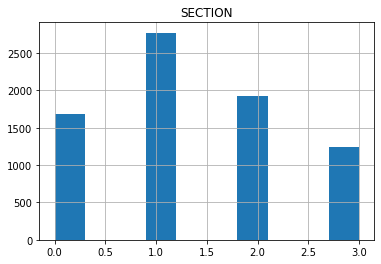

In [ ]:
df.hist()

In [ ]:
clean(test_set.STORY[0])

['gadget',
 'like',
 'gaming',
 'smartphone',
 'wearable',
 'medical',
 'device',
 'lift',
 'user',
 'experience',
 'new',
 'level',
 'mint',
 'india',
 'wire',
 'consumer',
 'technologyconsumer',
 'technology',
 'trend',
 'new',
 'yeartech',
 'gadgetsfoldable',
 'phonesgame',
 'smartphoneswearable',
 'medical',
 'devicestechnology',
 'new',
 'delhi',
 'gadget',
 'integral',
 'life',
 'rely',
 'form',
 'factor',
 'communicate',
 'commute',
 'work',
 'inform',
 'entertain',
 'year',
 'gadget',
 'lift',
 'user',
 'experience',
 'new',
 'level',
 'expect',
 'smartphone',
 'foldable',
 'screen',
 'foldable',
 'phone',
 'finally',
 'move',
 'concept',
 'stage',
 'commercial',
 'launch',
 'organic',
 'light',
 'emit',
 'diode',
 'ole',
 'panel',
 'high',
 'plastic',
 'substrate',
 'allow',
 'bent',
 'damage',
 'base',
 'display',
 'maker',
 'royole',
 'corp',
 'foldable',
 'phone',
 'flexpai',
 'arrive',
 'select',
 'market',
 'samsung',
 'unnamed',
 'foldable',
 'phone',
 'expect',
 'year',

In [ ]:
test_set.STORY[0]

'2019 will see gadgets like gaming smartphones and wearable medical devices lifting the user experience to a whole new level\n\n\nmint-india-wire consumer technologyconsumer technology trends in New Yeartech gadgetsFoldable phonesgaming smartphoneswearable medical devicestechnology\n\n\nNew Delhi: Gadgets have become an integral part of our lives with most of us relying on some form of factor to communicate, commute, work, be informed or entertained. Year 2019 will see some gadgets lifting the user experience to a whole new level. Here’s what we can expect to see:\n\n\nSmartphones with foldable screens: Foldable phones are finally moving from the concept stage to commercial launches. They are made up of organic light-emitting diode (OLED) panels with higher plastic substrates, allowing them to be bent without damage.\n\n\nUS-based display maker Royole Corp’s foldable phone, FlexPai, has already arrived in select markets, while Samsung’s unnamed foldable phone is expected sometime next 